<a href="https://colab.research.google.com/github/Sidshx/hardware_for_AI/blob/main/SAXPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
%%cuda
#include <stdio.h>
#include <cuda.h>
#include <stdlib.h>

__global__
void saxpy(int n, float a, float *x, float *y) {
  int i = blockIdx.x*blockDim.x + threadIdx.x;
  if (i < n) y[i] = a*x[i] + y[i];
}

int main() {
  const float a = 2.0f;
  const int min_pow = 15, max_pow = 25;
  const int blockSize = 256;

  // Print CSV header to stdout
  printf("N,total_ms,kernel_ms\n");

  for (int p = min_pow; p <= max_pow; p++) {
    int N = 1 << p;
    size_t bytes = N * sizeof(float);

    // Host alloc & init
    float *h_x = (float*)malloc(bytes);
    float *h_y = (float*)malloc(bytes);
    for (int i = 0; i < N; i++) {
      h_x[i] = 1.0f;
      h_y[i] = 2.0f;
    }

    // Device alloc
    float *d_x, *d_y;
    cudaMalloc(&d_x, bytes);
    cudaMalloc(&d_y, bytes);

    // Timing events
    cudaEvent_t start, mid, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&mid);
    cudaEventCreate(&stop);

    // Record total start (includes copies + kernel)
    cudaEventRecord(start);

    // Host → Device
    cudaMemcpy(d_x, h_x, bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_y, h_y, bytes, cudaMemcpyHostToDevice);

    // Kernel timing
    int grid = (N + blockSize - 1) / blockSize;
    cudaEventRecord(mid);
    saxpy<<<grid, blockSize>>>(N, a, d_x, d_y);
    cudaEventRecord(stop);

    // Wait and measure
    cudaEventSynchronize(stop);
    float total_ms = 0, kernel_ms = 0;
    cudaEventElapsedTime(&total_ms, start, stop);
    cudaEventElapsedTime(&kernel_ms, mid, stop);

    // Emit CSV line
    printf("%d,%.3f,%.3f\n", N, total_ms, kernel_ms);

    // Cleanup
    cudaFree(d_x);
    cudaFree(d_y);
    free(h_x);
    free(h_y);
    cudaEventDestroy(start);
    cudaEventDestroy(mid);
    cudaEventDestroy(stop);
  }
  return 0;
}


N,total_ms,kernel_ms
32768,7.841,7.728
65536,0.176,0.002
131072,0.344,0.002
262144,0.635,0.002
524288,1.026,0.002
1048576,1.825,0.002
2097152,3.541,0.002
4194304,6.875,0.002
8388608,13.817,0.016
16777216,28.930,0.002
33554432,65.624,0.003



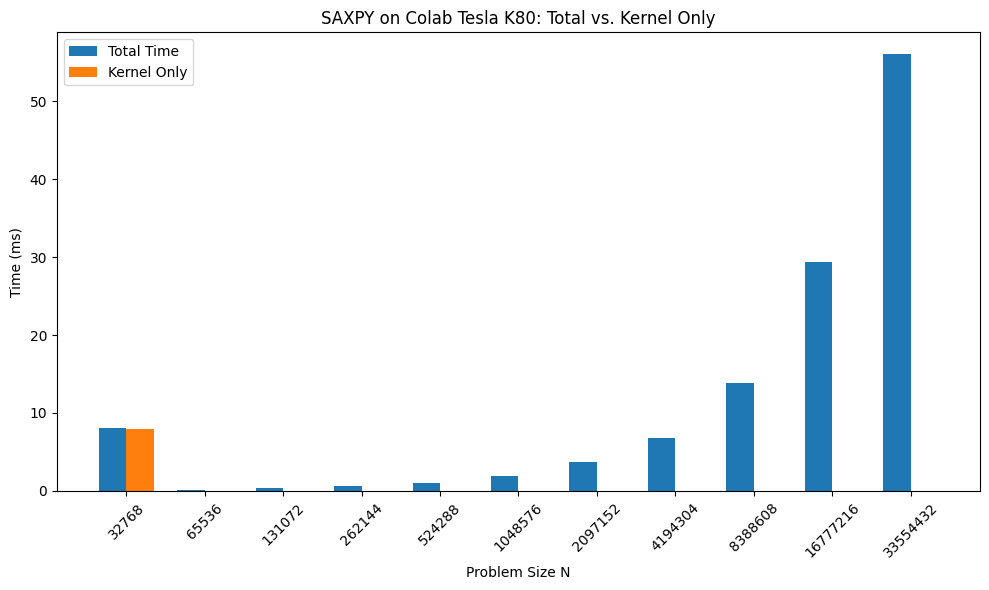

In [46]:
import pandas as pd
import io
import matplotlib.pyplot as plt

# Capture the stdout from the previous CUDA cell by manual copy-paste,
# or if using Colab API, you can redirect. For simplicity, paste as a raw string:

cuda_output = """
N,total_ms,kernel_ms
32768,8.137,8.003
65536,0.163,0.002
131072,0.322,0.002
262144,0.671,0.003
524288,1.034,0.002
1048576,1.880,0.002
2097152,3.730,0.003
4194304,6.856,0.003
8388608,13.899,0.003
16777216,29.374,0.003
33554432,56.010,0.003
"""

# Read into DataFrame
df = pd.read_csv(io.StringIO(cuda_output))
df['N_str'] = df['N'].astype(str)

# Plot
width = 0.35
x = range(len(df))
plt.figure(figsize=(10,6))
plt.bar(x, df['total_ms'], width, label='Total Time')
plt.bar([i+width for i in x], df['kernel_ms'], width, label='Kernel Only')
plt.xticks([i+width/2 for i in x], df['N_str'], rotation=45)
plt.xlabel('Problem Size N')
plt.ylabel('Time (ms)')
plt.title('SAXPY on Colab Tesla K80: Total vs. Kernel Only')
plt.legend()
plt.tight_layout()
plt.show()


In [49]:
%%cuda
#include <cstdio>
#include <cuda.h>
#include <cstdlib>

// SAXPY kernel
__global__
void saxpy(int n, float a, float *x, float *y) {
  int i = blockIdx.x*blockDim.x + threadIdx.x;
  if (i < n) y[i] = a*x[i] + y[i];
}

int main() {
  // Redirect stdout into results.csv
  freopen("results.csv","w",stdout);

  const float a = 2.0f;
  const int min_pow = 15, max_pow = 25;
  const int blockSize = 256;

  // CSV header
  printf("N,total_ms,kernel_ms\n");

  for (int p = min_pow; p <= max_pow; p++) {
    int N = 1 << p;
    size_t bytes = N * sizeof(float);

    // Host alloc & init
    float *h_x = (float*)malloc(bytes);
    float *h_y = (float*)malloc(bytes);
    for (int i = 0; i < N; i++) {
      h_x[i] = 1.0f;
      h_y[i] = 2.0f;
    }

    // Device alloc
    float *d_x, *d_y;
    cudaMalloc(&d_x, bytes);
    cudaMalloc(&d_y, bytes);

    // Events
    cudaEvent_t start, mid, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&mid);
    cudaEventCreate(&stop);

    // Time everything
    cudaEventRecord(start);
    cudaMemcpy(d_x, h_x, bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_y, h_y, bytes, cudaMemcpyHostToDevice);

    int grid = (N + blockSize - 1) / blockSize;
    cudaEventRecord(mid);
    saxpy<<<grid, blockSize>>>(N, a, d_x, d_y);
    cudaEventRecord(stop);

    cudaEventSynchronize(stop);
    float total_ms = 0, kernel_ms = 0;
    cudaEventElapsedTime(&total_ms, start, stop);
    cudaEventElapsedTime(&kernel_ms, mid, stop);

    // Write one CSV line
    printf("%d,%.3f,%.3f\n", N, total_ms, kernel_ms);

    // Cleanup
    cudaFree(d_x);
    cudaFree(d_y);
    free(h_x);
    free(h_y);
    cudaEventDestroy(start);
    cudaEventDestroy(mid);
    cudaEventDestroy(stop);
  }
  return 0;
}


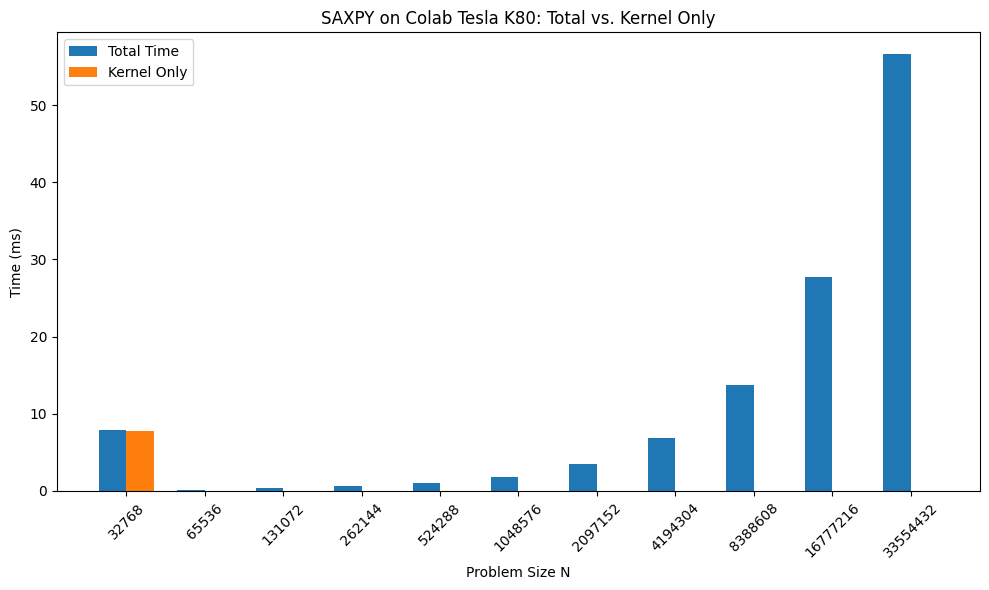

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the file your CUDA code just wrote
df = pd.read_csv('results.csv')
df['N_str'] = df['N'].astype(str)

# Draw grouped bar chart
width = 0.35
x = range(len(df))

plt.figure(figsize=(10,6))
plt.bar(x, df['total_ms'], width, label='Total Time')
plt.bar([i+width for i in x], df['kernel_ms'], width, label='Kernel Only')
plt.xticks([i+width/2 for i in x], df['N_str'], rotation=45)
plt.xlabel('Problem Size N')
plt.ylabel('Time (ms)')
plt.title('SAXPY on Colab Tesla K80: Total vs. Kernel Only')
plt.legend()
plt.tight_layout()
plt.show()


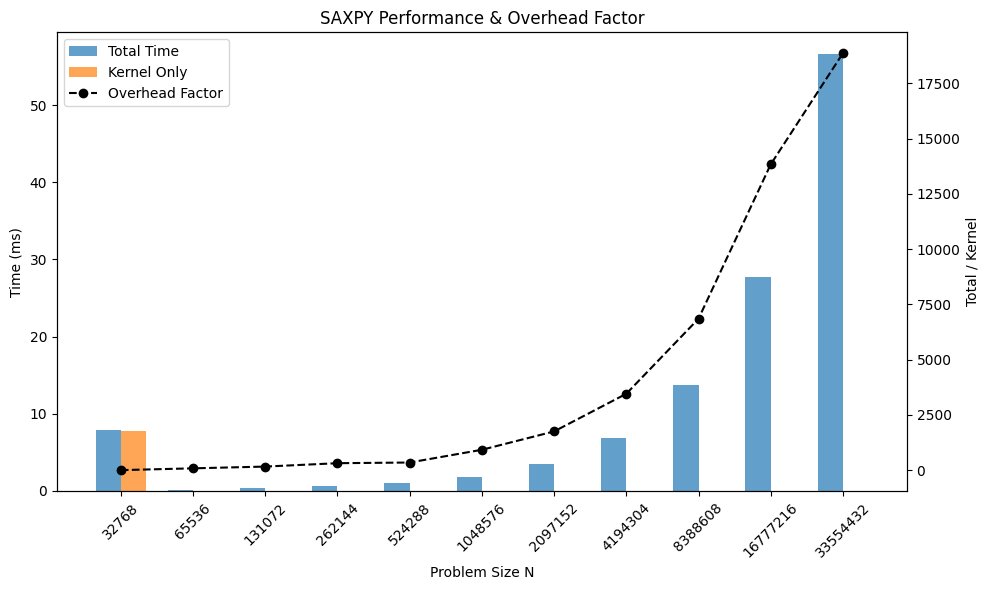

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('results.csv')
df['N_str'] = df['N'].astype(str)

fig, ax1 = plt.subplots(figsize=(10,6))

# Bar chart for total/kernel
width = 0.35
x = range(len(df))
ax1.bar(x, df['total_ms'], width, label='Total Time', alpha=0.7)
ax1.bar([i+width for i in x], df['kernel_ms'], width, label='Kernel Only', alpha=0.7)
ax1.set_xlabel('Problem Size N')
ax1.set_ylabel('Time (ms)')
ax1.set_xticks([i+width/2 for i in x])
ax1.set_xticklabels(df['N_str'], rotation=45)

# Line plot for the ratio (total/kernel) on a secondary axis
ax2 = ax1.twinx()
ratio = df['total_ms'] / df['kernel_ms']
ax2.plot([i+width/2 for i in x], ratio, color='black', marker='o', linestyle='--', label='Overhead Factor')
ax2.set_ylabel('Total / Kernel')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('SAXPY Performance & Overhead Factor')
plt.tight_layout()
plt.show()


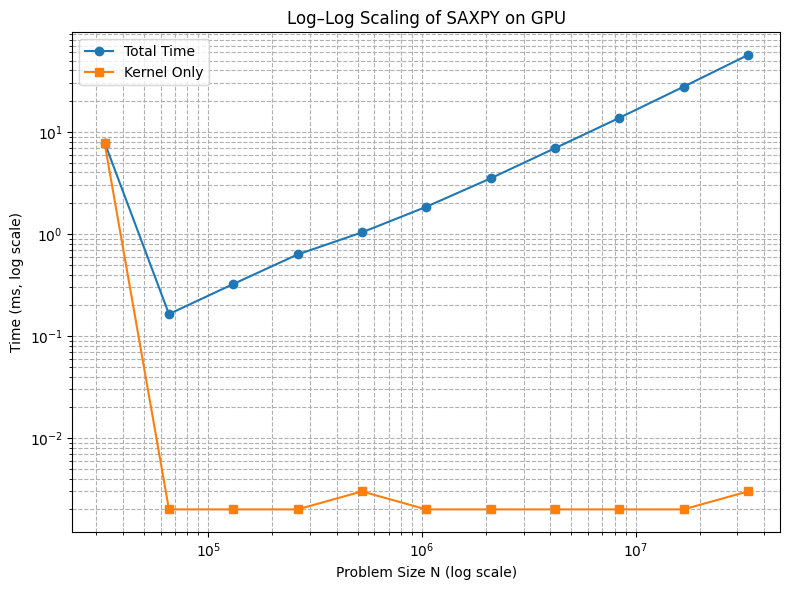

In [52]:
plt.figure(figsize=(8,6))
plt.loglog(df['N'], df['total_ms'], marker='o', label='Total Time')
plt.loglog(df['N'], df['kernel_ms'], marker='s', label='Kernel Only')
plt.xlabel('Problem Size N (log scale)')
plt.ylabel('Time (ms, log scale)')
plt.title('Log–Log Scaling of SAXPY on GPU')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


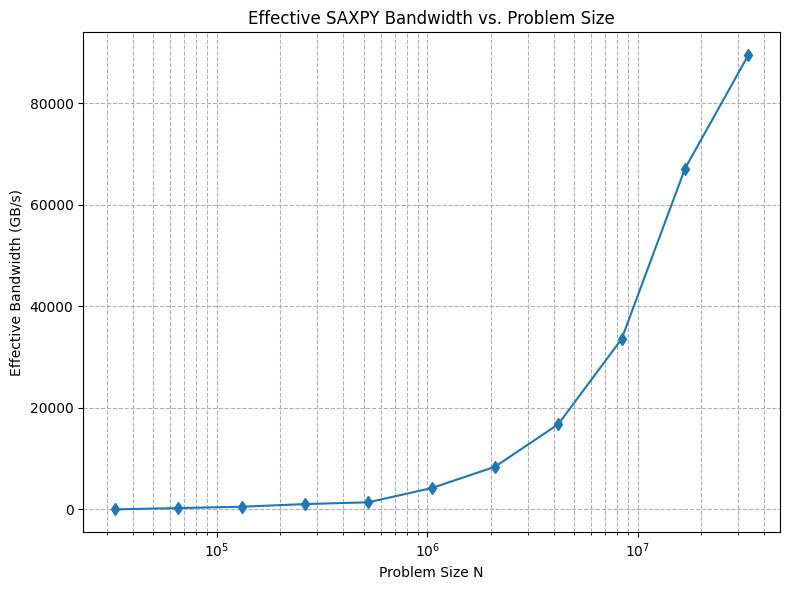

In [53]:
# Compute bandwidth in GB/s
df['bandwidth_gbps'] = (2 * df['N'] * 4) / (df['kernel_ms'] / 1000) / 1e9

plt.figure(figsize=(8,6))
plt.plot(df['N'], df['bandwidth_gbps'], marker='d')
plt.xscale('log')
plt.xlabel('Problem Size N')
plt.ylabel('Effective Bandwidth (GB/s)')
plt.title('Effective SAXPY Bandwidth vs. Problem Size')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()
